In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12,8)

In [11]:
# Read and view data

df = pd.read_csv(r'...\movies.csv')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [12]:
# Drop unnecessary column and zoom into more known/voted movies
# Nulls dropped here for simplicity's sake

df = df.drop(columns = 'released')
df = df.drop(df[df['votes'] < 200000].index)
df = df.drop(df[df['genre'] == 'Animation'].index)
df = df.drop(df[df['company'] == 'Marvel Studios'].index)
df = df.dropna()
df = df.reset_index(drop=True)

df.dtypes

name         object
rating       object
genre        object
year          int64
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

In [13]:
# Order movies by IMDb score

for i in ['votes', 'budget', 'gross', 'runtime']:
    df[i] = df[i].astype('int64')
    
df.sort_values(by=['score'], inplace=True, ascending=False)
df = df.reset_index(drop=True)

# Current dataset only shows 1 actor per movie
# To scrape more cast data from the IMDb site later. we need each movie's title ID
df.insert(0, 'Title ID', "")

df.head(3)

,Title ID,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
0,,The Shawshank Redemption,R,Drama,1994,9.3,2400000,Frank Darabont,Stephen King,Tim Robbins,United States,25000000,28817291,Castle Rock Entertainment,142
1,,The Dark Knight,PG-13,Action,2008,9.0,2400000,Christopher Nolan,Jonathan Nolan,Christian Bale,United States,185000000,1005973645,Warner Bros.,152
2,,Pulp Fiction,R,Crime,1994,8.9,1900000,Quentin Tarantino,Quentin Tarantino,John Travolta,United States,8000000,213928762,Miramax,154


In [14]:
# Read in secondary dataset which has all IMDb movie title IDs

df2 = pd.read_csv(r'...\IMDb movies.csv')
df2.head(3)

C:\Users\canno\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0


In [15]:
# Mapping over title IDs from the secondary dataset to our primary dataframe

for movie in df['name']:
    if ((df2['original_title'] == movie) & (df2['director'] == df.loc[df['name'] == movie, 'director'].iloc[0])).any() == True:
        df.loc[df['name'] == movie, 'Title ID'] = df2.loc[((df2['original_title'] == movie) & (df2['director'] == df.loc[df['name'] == movie, 'director'].iloc[0])), 'imdb_title_id'].iloc[0]
    elif ((df2['title'] == movie) & (df2['director'] == df.loc[df['name'] == movie, 'director'].iloc[0])).any() == True:
        df.loc[df['name'] == movie, 'Title ID'] = df2.loc[((df2['title'] == movie) & (df2['director'] == df.loc[df['name'] == movie, 'director'].iloc[0])), 'imdb_title_id'].iloc[0]
    else:
        df.loc[df['name'] == movie, 'Title ID'] = np.NaN
        
df.head(3)

,Title ID,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
0,tt0111161,The Shawshank Redemption,R,Drama,1994,9.3,2400000,Frank Darabont,Stephen King,Tim Robbins,United States,25000000,28817291,Castle Rock Entertainment,142
1,tt0468569,The Dark Knight,PG-13,Action,2008,9.0,2400000,Christopher Nolan,Jonathan Nolan,Christian Bale,United States,185000000,1005973645,Warner Bros.,152
2,tt0110912,Pulp Fiction,R,Crime,1994,8.9,1900000,Quentin Tarantino,Quentin Tarantino,John Travolta,United States,8000000,213928762,Miramax,154


In [16]:
# Checking how many title IDs were unable to be mapped over due to various reasons

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, pct_missing*100))

Title ID - 9.07960199004975%
name - 0.0%
rating - 0.0%
genre - 0.0%
year - 0.0%
score - 0.0%
votes - 0.0%
director - 0.0%
writer - 0.0%
star - 0.0%
country - 0.0%
budget - 0.0%
gross - 0.0%
company - 0.0%
runtime - 0.0%


In [17]:
df = df.dropna()
df = df.reset_index(drop=True)
df.describe()

,year,score,votes,budget,gross,runtime
count,731.000000,731.000000,7.310000e+02,7.310000e+02,7.310000e+02,731.000000
mean,2006.227086,7.253762,4.209549e+05,7.124301e+07,3.087113e+08,122.590971
std,8.733050,0.728215,2.900551e+05,6.129217e+07,3.000778e+08,21.090824
min,1980.000000,3.800000,2.000000e+05,1.500000e+04,3.047100e+04,80.000000
25%,2001.000000,6.800000,2.440000e+05,2.500000e+07,1.071313e+08,108.000000
50%,2008.000000,7.300000,3.220000e+05,5.000000e+07,2.198512e+08,120.000000
75%,2013.000000,7.800000,4.750000e+05,1.020000e+08,4.009170e+08,134.000000
max,2020.000000,9.300000,2.400000e+06,3.170000e+08,2.847246e+09,229.000000


[Text(0.5, 1.0, 'Budget vs Gross Revenue')]

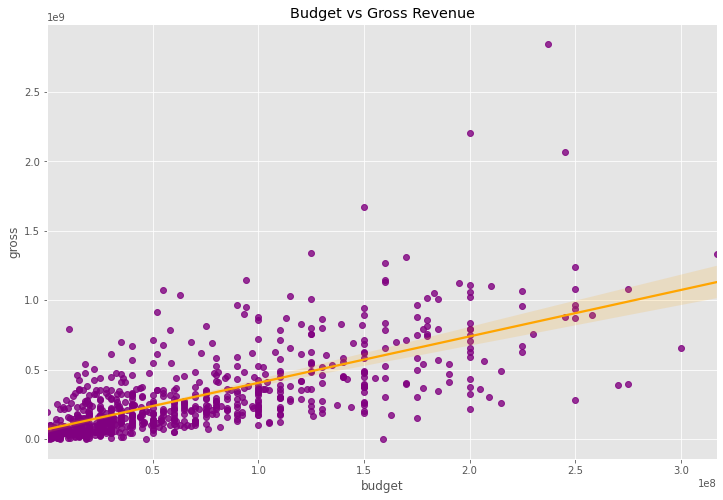

In [18]:
# Linear regression scatter plot of movie budget against gross revenue

sns.regplot(data=df, x='budget', y='gross', scatter_kws={'color':'purple'}, line_kws={'color':'orange'}).set(title='Budget vs Gross Revenue')

[Text(0.5, 1.0, 'Score vs Gross Revenue')]

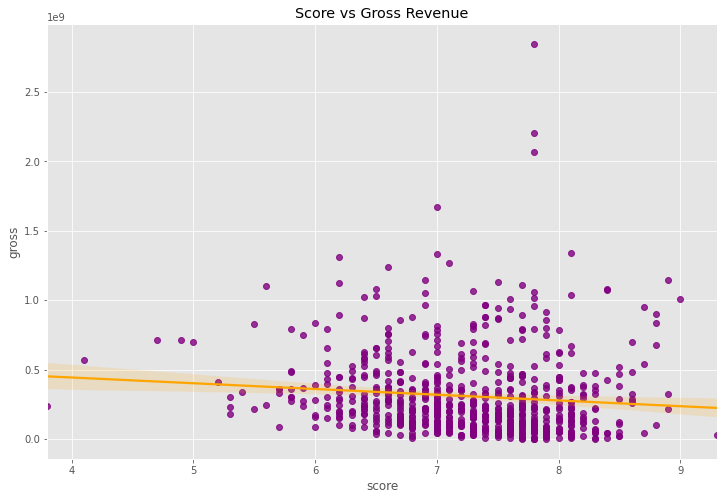

In [19]:
# Linear regression scatter plot of movie score against gross revenue

sns.regplot(data=df, x='score', y='gross', scatter_kws={'color':'purple'}, line_kws={'color':'orange'}).set(title='Score vs Gross Revenue')

C:\Users\canno\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 24.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\canno\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 36.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, 'Gross Revenue by Genre')]

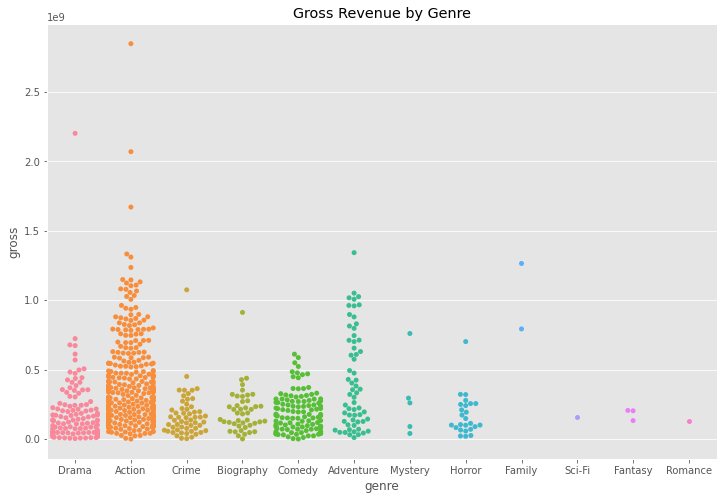

In [20]:
# Swarm plot of gross revenue by movie genre

sns.swarmplot(x='genre', y='gross', data=df).set(title='Gross Revenue by Genre')

C:\Users\canno\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 27.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0.5, 1.0, 'Score by Genre')]

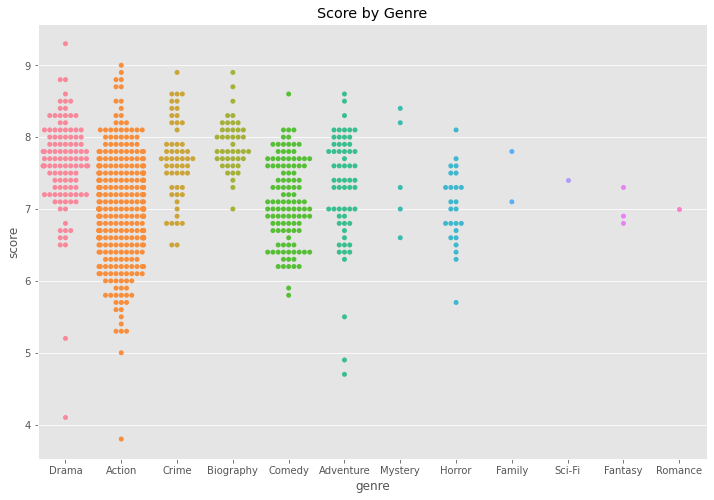

In [21]:
# Swarm plot of movie score by movie genre

sns.swarmplot(x='genre', y='score', data=df).set(title='Score by Genre')

In [22]:
# Correlation matrix between numeric columns

df.corr(method='pearson')

,year,score,votes,budget,gross,runtime
year,1.000000,-0.239167,-0.108629,0.321022,0.203237,-0.006181
score,-0.239167,1.000000,0.566572,-0.307052,-0.100290,0.290762
votes,-0.108629,0.566572,1.000000,0.122878,0.324204,0.338545
budget,0.321022,-0.307052,0.122878,1.000000,0.682929,0.361498
gross,0.203237,-0.100290,0.324204,0.682929,1.000000,0.321602
runtime,-0.006181,0.290762,0.338545,0.361498,0.321602,1.000000


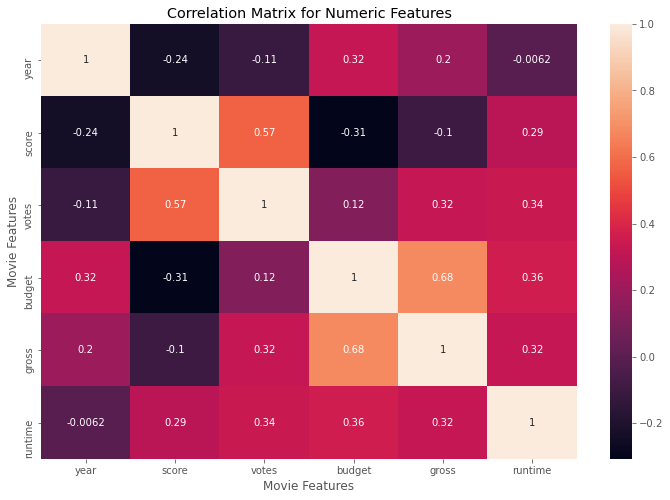

In [23]:
# Correlation heatmap for numeric features

corr = df.corr(method='pearson')

sns.heatmap(corr, annot=True)

plt.title('Correlation Matrix for Numeric Features')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')
plt.show()

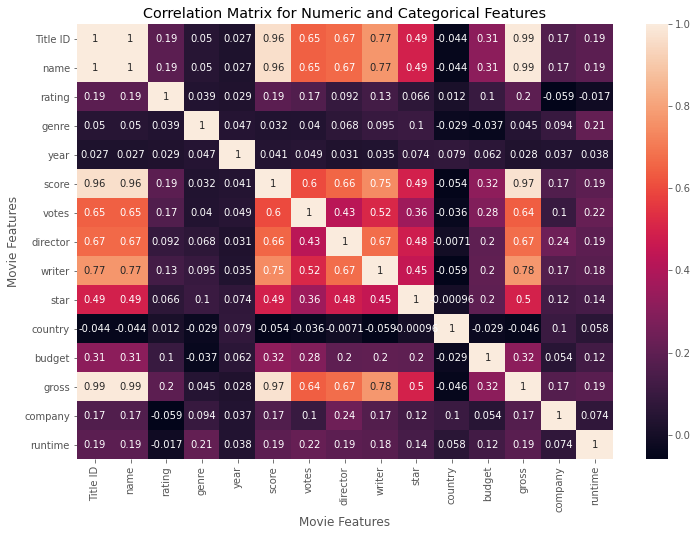

In [24]:
# Correlation heatmap for both categorical and numeric features

corr_matrix = df.apply(lambda x: x.factorize()[0]).corr(method='pearson')

sns.heatmap(corr_matrix, annot=True)

plt.title('Correlation Matrix for Numeric and Categorical Features')
plt.xlabel('Movie Features')
plt.ylabel('Movie Features')
plt.show()

In [26]:
# Feature pairs with strong correlations

corr_pairs = corr_matrix.unstack().sort_values()
strong_pairs = corr_pairs[abs(corr_pairs > 0.75)]
strong_pairs

Title ID  writer      0.770735
name      writer      0.770735
writer    Title ID    0.770735
          name        0.770735
gross     writer      0.776385
writer    gross       0.776385
Title ID  score       0.964811
name      score       0.964811
score     Title ID    0.964811
          name        0.964811
          gross       0.971621
gross     score       0.971621
name      gross       0.993440
gross     name        0.993440
          Title ID    0.993440
Title ID  gross       0.993440
          Title ID    1.000000
director  director    1.000000
gross     gross       1.000000
budget    budget      1.000000
country   country     1.000000
star      star        1.000000
writer    writer      1.000000
votes     votes       1.000000
score     score       1.000000
year      year        1.000000
genre     genre       1.000000
rating    rating      1.000000
name      name        1.000000
          Title ID    1.000000
Title ID  name        1.000000
company   company     1.000000
runtime 

In [27]:
# Scrape from the IMDb website the top 5 actors of each movie and store in "star" column

list_of_lists = []

for title_id in df['Title ID']:
    stars_list = []
    url = 'https://www.imdb.com/title/{}/'.format(title_id)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    stars = soup.find_all('a', {'data-testid':'title-cast-item__actor'})[:5]
    
    for star in stars:
        stars_list.append(star.text)
        
    list_of_lists.append(stars_list)

df['star'] = list_of_lists
df.head(3)

<ipython-input-27-dacd8fe8a9ed>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7up['star'] = list_of_lists # change df name after running


,Title ID,name,rating,genre,year,score,votes,director,writer,star,country,budget,gross,company,runtime
0,tt0111161,The Shawshank Redemption,R,Drama,1994,9.3,2400000,Frank Darabont,Stephen King,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",United States,25000000,28817291,Castle Rock Entertainment,142
1,tt0468569,The Dark Knight,PG-13,Action,2008,9.0,2400000,Christopher Nolan,Jonathan Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",United States,185000000,1005973645,Warner Bros.,152
2,tt0110912,Pulp Fiction,R,Crime,1994,8.9,1900000,Quentin Tarantino,Quentin Tarantino,"[John Travolta, Uma Thurman, Samuel L. Jackson...",United States,8000000,213928762,Miramax,154


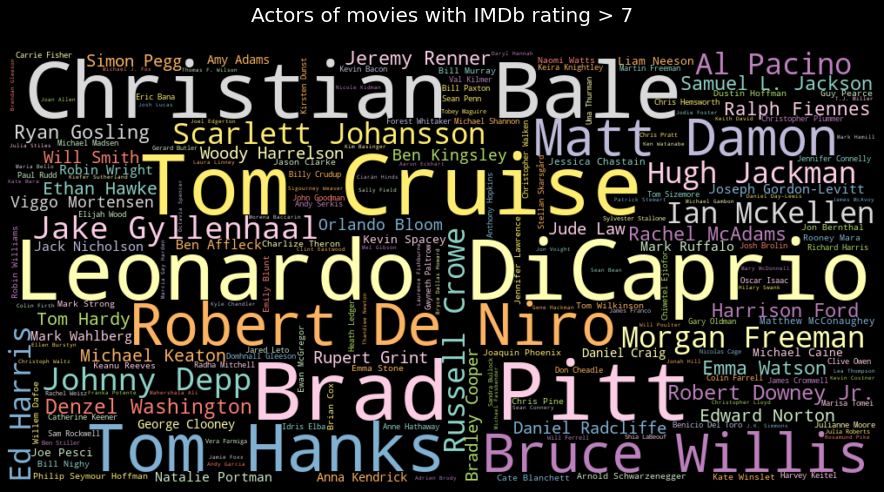

In [30]:
# Word cloud of actors from movies with IMDb rating of 7 and above

df_7up = df.loc[df['score'] >= 7]

temp_list = []
for row in df_7up.star:
    for name in row:
        temp_list.append(name)

actor_text = Counter(temp_list)

wordcloud = WordCloud(width=1000, height=500, background_color='black', colormap='Set3').generate_from_frequencies(actor_text)

plt.figure(figsize=(16,8), facecolor='black')
plt.title('Actors of movies with IMDb rating > 7\n', {'color':'white', 'fontsize':20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

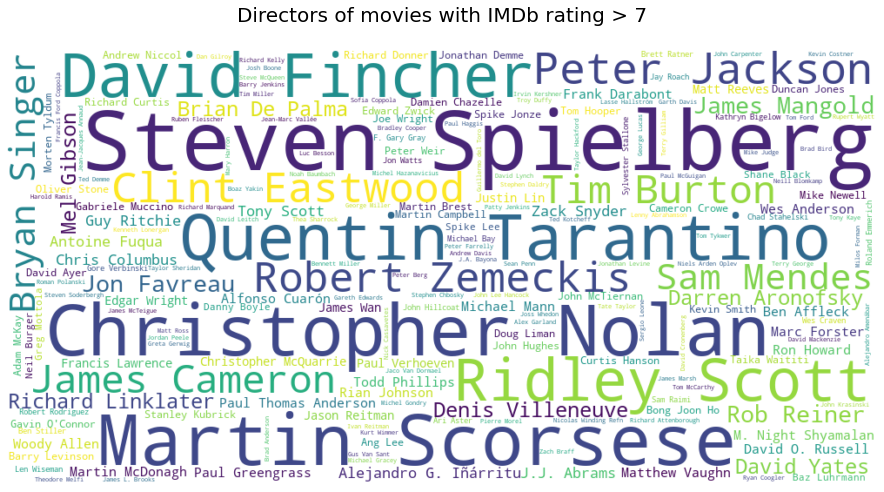

In [31]:
# Word cloud of directos from movies with IMDb rating of 7 and above

director_text = Counter(df_7up.director)

wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate_from_frequencies(director_text)

plt.figure(figsize=(16,8))
plt.title('Directors of movies with IMDb rating > 7\n', {'fontsize':20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()